In [29]:
# %load prl-hubbard/DMFT.py
from typing import Callable
import numpy as np
from scipy import sparse
from scipy import optimize
from itertools import product
import math
from matplotlib import pyplot as plt
from qat.fermion.hamiltonians import make_anderson_model
from qat.fermion.util import init_creation_ops


def creeHAIM(epsilons_t: list[float], v: list[float], U: float, mu: float, sparse=True):
    return make_anderson_model(u=U, mu=mu, v=v, epsilon=epsilons_t).get_matrix(sparse)


def diag_AIM(epsilons_t: list[float], v: list[float], U: float, mu: float) -> tuple[
    np.ndarray[float], np.ndarray[float]]:
    """Donne les valeurs propre et vecteurs propres du modele d'impurete  du modele d'impurete AIM"""
    HAIM = creeHAIM(epsilons_t, v, U, mu, sparse=False)
    # valeurs_prop, vecteurs_prop = sparse.linalg.eigs(HAIM, which="SR", k=HAIM.shape[0] - 2)
    #valeurs_prop, vecteurs_prop = sparse.linalg.eigsh(HAIM, which="SR", k=int(HAIM.shape[0]-2))
    valeurs_prop, vecteurs_prop = np.linalg.eigh(HAIM)
    return valeurs_prop, vecteurs_prop


def G_loc_base(omega: float, t: float, mu: float, p1: int, p2: int, p3: int, sig_imp_omega) -> float:
    S = 0
    #for alpha1, alpha2, alpha3 in product(range(p1), range(p2), range(p3)):
    for alpha1, alpha2 in product(range(p1), range(p2)):
        energie_k = -2*t * (
                np.cos(2 * np.pi * alpha1 / (p1)) 
                + np.cos(2 * np.pi * alpha2 / (p2))
                #+ np.cos(2 * np.pi * alpha3 / (p3))
                )
        S += 1 / (omega * 1j + mu - energie_k - sig_imp_omega)
    nk = p1 * p2 #* p3
    return S / nk


def G_Lehman(valeurs_prop: np.ndarray[float], vecteurs_prop: np.ndarray[float], beta: float, n_site_bain, omegas):
    n_site = n_site_bain + 1
    dim, nb_vp = np.shape(vecteurs_prop)
    
    valeurs_prop = valeurs_prop - min(valeurs_prop)
    Z = np.sum(np.exp(-beta*valeurs_prop))
    cdag = init_creation_ops(n_site*2)
    
    # checking occupancy
    n_imp = cdag[0].dot(cdag[0].T.conj())
    n_imp += cdag[1].dot(cdag[1].T.conj())
    occ = np.sum([np.exp(-beta*valeurs_prop[i])*vecteurs_prop[: ,i].conj().dot(n_imp.dot(vecteurs_prop[:, i]))
                  for i in range(nb_vp)])/Z
    print("occ = ", occ)
    
    N = len(omegas)
    resu = np.zeros(N,dtype = 'complex_')
    for i, j in product(range(nb_vp), repeat=2):
        prod_scal = abs(vecteurs_prop[:, j].conj().dot(cdag[0].dot(vecteurs_prop[:, i])))**2
        for n in range(N):
            resu[n] += ((np.exp(-beta*valeurs_prop[i]) + np.exp(-beta*valeurs_prop[j])) * prod_scal ) / (
                    valeurs_prop[j] - valeurs_prop[i] - 1j * omegas[n])
    return -resu/Z


def delta_appro(omega: float, *args) -> float:
    x = list(args)
    n = len(x) // 2
    epsilons_t = np.array(x[:n])
    v = np.array(x[n:])
    Delta = np.array([np.sum(v ** 2 / (1j*om - epsilons_t)) for om in omega])
    return np.array(list(Delta.real) + list(Delta.imag))

def fit_curve(delta : list[float], omegas : list[float], n:int):

    x_in = np.array(list(omegas))
    y_in = np.array(list(delta.real) + list(delta.imag))

    init = np.ones(2 * n)
    popt, pcov = optimize.curve_fit(delta_appro, x_in, y_in, p0=init,maxfev=10000)

    return popt, pcov


def DMFT(precision: float, U: float, t: float, mu: float, beta: float, p1: int, p2: int, p3: int, n_site_bain: int,N:int):
    """pave droit de cotes p1 p2 p3
    Converge quand Gimp^n+1 - Gimp^n < precision
    N : borne sup pour le calcul des frequences omega_n
    """

    omegas = [(2 * n + 1) * 2 * np.pi / beta for n in range(N)]
    sig_imp = mu*np.ones(N)

    g_imp_n = math.inf*np.ones(N)
    g_imp_nplus1 = np.zeros(N)
    
    data = {}

    eps = 0
    loop_ind = 0
    diff  = precision + 1
    while diff > precision:
        
        print(f"=== DMFT loop {loop_ind} ===")

        G_loc = np.array([G_loc_base(omegas[n], t, mu, p1, p2, p3, sig_imp[n]) for n in range(N)])
        G_ronde = np.array([1/(sig_imp[n] +  1 / G_loc[n]) for n in range(N)])
        delta = np.array([omegas[n] * 1j + mu - 1 / G_ronde[n] for n in range(N)])

        x, pcov = fit_curve(delta = delta,omegas = omegas, n=n_site_bain)
        delta_fit = delta_appro(omegas, *x)
        delta_fit = delta_fit[:len(delta_fit)//2] + 1j*delta_fit[len(delta_fit)//2:]

        G_ronde_fit = np.array([1/(omegas[n] * 1j + mu - delta_fit[n]) for n in range(N)])
        epsilons_t = x[:n_site_bain]
        v = x[n_site_bain:]
        print("Hyb: ", epsilons_t, v)
        valeurs_prop, vecteurs_prop = diag_AIM(epsilons_t, v, U, mu)
       

        g_imp_n = g_imp_nplus1
        g_imp_nplus1 = (1-eps) * G_Lehman(valeurs_prop, vecteurs_prop, beta, n_site_bain, omegas) + eps*g_imp_nplus1

        sig_imp = np.array([1/G_ronde_fit[n] - 1 / g_imp_nplus1[n] for n in range(N)])
        
        diff = np.linalg.norm(g_imp_nplus1-g_imp_n)
        print(f" => diff: {diff}")
        loop_ind += 1
        
        
        
        data[f"g_loc_{loop_ind}"] = G_loc
        data[f"g_ronde_{loop_ind}"] = G_ronde
        data[f"g_ronde_fit_{loop_ind}"] = G_ronde_fit
        data[f"delta_{loop_ind}"] = delta
        data[f"delta_fit_{loop_ind}"] = delta_fit
        data[f"g_imp_nplus1_{loop_ind}"] = g_imp_nplus1
        data[f"sig_imp_{loop_ind}"] = sig_imp
        
        if loop_ind >= 10: # not more than 10 loops
            break

    return sig_imp,g_imp_nplus1,valeurs_prop,vecteurs_prop, data

## Example for one value of $U$

In [47]:
precision = 0.001
U = 6.0
t = 1.0
mu = U/2
beta = 20
p1 = p2 = p3 = 10
n_site_bain = 2
N = 100
sig_imp, g_imp_nplus1, valeurs_prop, vecteurs_prop, data = DMFT(precision = precision,
                                                                U = U,t= t ,mu= mu,
                                                                beta= beta,p1=p1,p2=p2,p3=p3,
                                                                n_site_bain=n_site_bain,N=N)

=== DMFT loop 0 ===
Hyb:  [ 1.23707275 -1.237058  ] [1.31840199 1.31839806]
occ =  (1.0000004507091715+0j)
 => diff: 0.8815316567593733
=== DMFT loop 1 ===
Hyb:  [ 1.0340824  -1.03399063] [1.19383446 1.19380802]
occ =  (1.0000026091147325+0j)
 => diff: 0.02576561539777043
=== DMFT loop 2 ===
Hyb:  [ 0.99630556 -0.996187  ] [1.18047136 1.18043452]
occ =  (1.0000032679767927+0j)
 => diff: 0.008334571503469215
=== DMFT loop 3 ===
Hyb:  [ 0.98531    -0.98520512] [1.17805247 1.17801845]
occ =  (1.0000028524523379+0j)
 => diff: 0.0028253860253853336
=== DMFT loop 4 ===
Hyb:  [-0.98165633  0.9817514 ] [1.17739642 1.1774274 ]
occ =  (1.0000025792811573+0j)
 => diff: 0.0009456460007485675


## Plots for one loop index

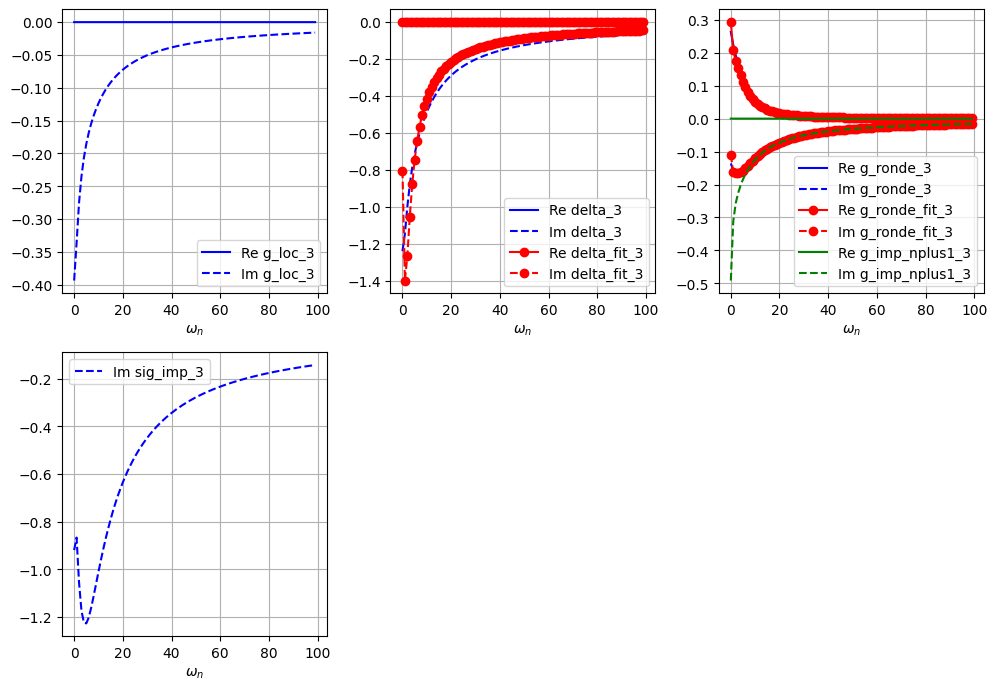

In [48]:
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(10, 10))
gs = GridSpec(3,3)
cols = ['b', 'or', 'g']
obs_list = [("g_loc",), ("delta", "delta_fit"), ("g_ronde", "g_ronde_fit", "g_imp_nplus1"), ("sig_imp",)]
for sub, obs_t in enumerate(obs_list):
    loop_ind = 3
    plt.subplot(gs[sub])
    for col, obs in enumerate(obs_t):
        if "sig" not in obs:
            plt.plot(data[f"{obs}_{loop_ind}"].real, "-"+cols[col], label=f"Re {obs}_{loop_ind}")
        plt.plot(data[f"{obs}_{loop_ind}"].imag, "--"+cols[col], label=f"Im {obs}_{loop_ind}")
    plt.xlabel(r"$\omega_n$")
    plt.legend()
    #plt.xlim(0,20)
    plt.grid()
plt.tight_layout()

## Plots for several loop indices

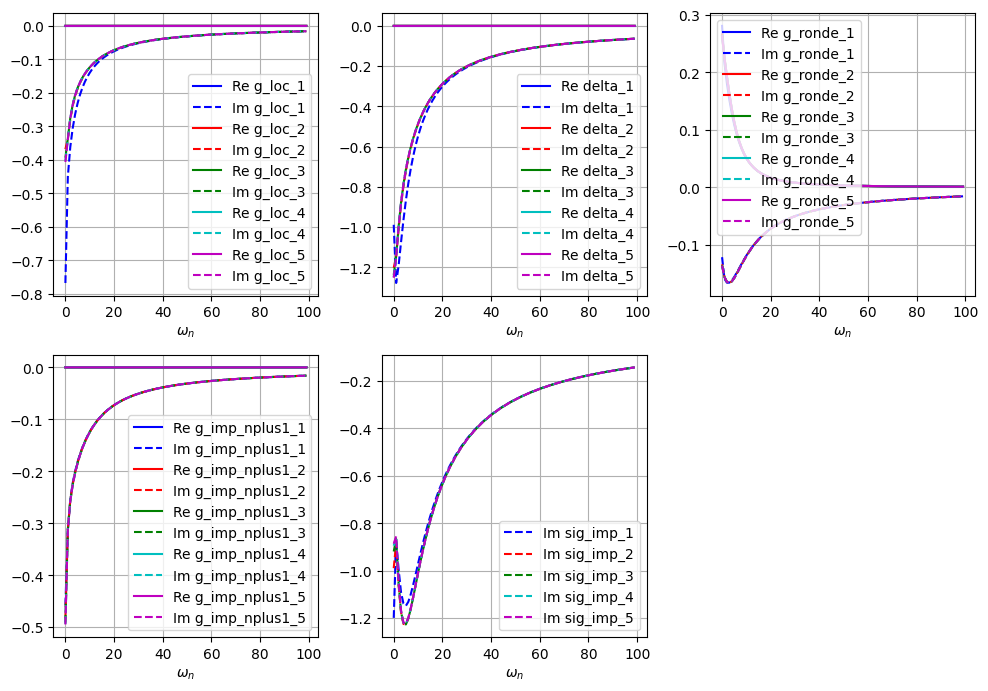

In [49]:
plt.figure(figsize=(10, 10))
gs = GridSpec(3,3)
cols = ['b', 'r', 'g', 'c', 'm']
obs_list = ["g_loc", "delta","g_ronde", "g_imp_nplus1", "sig_imp"]
for sub, obs in enumerate(obs_list):
    plt.subplot(gs[sub])
    for col, loop_ind in enumerate(range(1,6)):
        try:
            if "sig" not in obs:
                plt.plot(data[f"{obs}_{loop_ind}"].real, "-"+cols[col], label=f"Re {obs}_{loop_ind}")
            plt.plot(data[f"{obs}_{loop_ind}"].imag, "--"+cols[col], label=f"Im {obs}_{loop_ind}")
        except:
            pass
    plt.xlabel(r"$\omega_n$")
    plt.legend()
    #plt.xlim(0,20)
    plt.grid()
plt.tight_layout()

## Locating the Mott transition

In [57]:
U_list = np.linspace(0, 15, 10)

data = {}
for U in U_list:
    print(f"=== U = {U} ===")
    precision = 0.0001
    t = 1.0
    mu = U/2
    beta = 20
    p1 = p2 = p3 = 10
    n_site_bain = 2
    N = 100
    sig_imp, g_imp_nplus1, valeurs_prop, vecteurs_prop, data[U] = DMFT(precision = precision,
                                                                       U = U,t= t ,mu= mu,
                                                                       beta=beta,p1=p1,p2=p2,p3=p3,
                                                                       n_site_bain=n_site_bain,N=N)

=== U = 0.0 ===
=== DMFT loop 0 ===
Hyb:  [ 1.23707275 -1.237058  ] [1.31840199 1.31839806]
occ =  (0.999994405483306+0j)
 => diff: 1.3733495184755309
=== DMFT loop 1 ===
Hyb:  [ 1.23707275 -1.237058  ] [1.31840199 1.31839806]
occ =  (0.9999944052314923+0j)
 => diff: 4.835671128079291e-10
=== U = 1.6666666666666667 ===
=== DMFT loop 0 ===
Hyb:  [ 1.23707316 -1.23706764] [1.31840213 1.31840067]
occ =  (0.9999996430481346+0j)
 => diff: 1.3073219516243515
=== DMFT loop 1 ===
Hyb:  [ 1.17385096 -1.17383364] [1.29936898 1.29936403]
occ =  (0.9999987871351705+0j)
 => diff: 0.03411941316008873
=== DMFT loop 2 ===
Hyb:  [ 1.17946455 -1.1794524 ] [1.30061493 1.30061104]
occ =  (0.9999993998244363+0j)
 => diff: 0.003520388500733455
=== DMFT loop 3 ===
Hyb:  [ 1.17891221 -1.17889499] [1.30048978 1.30048475]
occ =  (0.9999988780022198+0j)
 => diff: 0.0003444434424353432
=== DMFT loop 4 ===
Hyb:  [ 1.17896837 -1.17895494] [1.30050271 1.30049849]
occ =  (0.9999992849292159+0j)
 => diff: 3.5924257663

 => diff: 0.1418486136277118
=== DMFT loop 2 ===
Hyb:  [5.12978522 1.1102152 ] [1.25265832 0.30828529]
occ =  (0.9876329058376573+0j)
 => diff: 0.05286157308337046
=== DMFT loop 3 ===
Hyb:  [-6.79816869  5.73624945] [-1.39210914  1.39482926]
occ =  (0.9980675702273856+0j)
 => diff: 0.024114200481767507
=== DMFT loop 4 ===
Hyb:  [-6.11344817  5.92745125] [1.39088416 1.38913775]
occ =  (0.9996795795390987+0j)
 => diff: 0.003973245975358732
=== DMFT loop 5 ===
Hyb:  [5.23651941 2.64942512] [1.29925451e+00 9.96834863e-05]
occ =  (0.9884954819885599+0j)
 => diff: 0.025612511597153886
=== DMFT loop 6 ===
Hyb:  [ 5.88414403 -6.80352522] [-1.40004898  1.39355244]
occ =  (0.9982865217301462+0j)
 => diff: 0.022076200396476463
=== DMFT loop 7 ===
Hyb:  [-6.11310166  5.95071455] [1.39110911 1.38974384]
occ =  (0.9997183370673355+0j)
 => diff: 0.0036763977776853403
=== DMFT loop 8 ===
Hyb:  [5.23960736 3.34536283] [1.29929990e+00 2.24399463e-04]
occ =  (0.988500468173476+0j)
 => diff: 0.02566080207

/usr/local/lib64/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


 => diff: 0.03443332184917398
=== DMFT loop 3 ===
Hyb:  [ 6.73733158 -7.61090616] [ 1.40095464 -1.39684162]
occ =  (0.9988753871865725+0j)
 => diff: 0.017381583880093525
=== DMFT loop 4 ===
Hyb:  [-6.98532125  6.86455212] [1.39523526 1.39434269]
occ =  (0.9998560223636783+0j)
 => diff: 0.002279771957078977
=== DMFT loop 5 ===
Hyb:  [2.45073518 5.92988104] [-4.14759111e-05  1.29056890e+00]
occ =  (0.9910136054087326+0j)
 => diff: 0.01889475273491925
=== DMFT loop 6 ===
Hyb:  [ 6.8078915  -7.61319465] [1.40281453 1.39749063]
occ =  (0.9989506450852408+0j)
 => diff: 0.016767010261162438
=== DMFT loop 7 ===
Hyb:  [-6.98515581  6.87324243] [1.39531597 1.39453228]
occ =  (0.9998661287748971+0j)
 => diff: 0.0021881686871790033
=== DMFT loop 8 ===
Hyb:  [2.09299722 5.93075995] [-3.59214492e-05  1.29057513e+00]
occ =  (0.9910146654918012+0j)
 => diff: 0.018906851316340238
=== DMFT loop 9 ===
Hyb:  [ 6.80802704 -7.61319678] [1.40281764 1.39749202]
occ =  (0.9989507989594429+0j)
 => diff: 0.01676

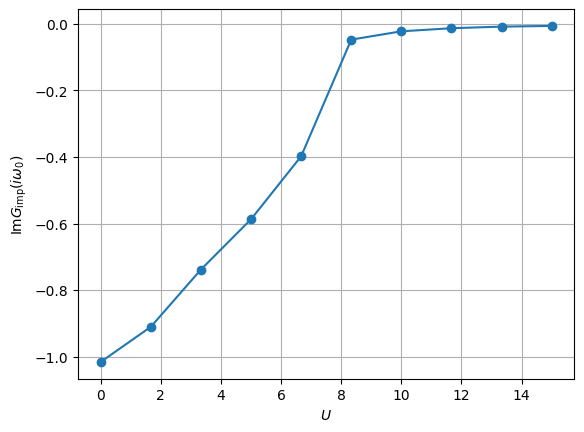

In [63]:
val_list = []
for U in U_list:
    #obs = "sig_imp"
    obs = "g_imp_nplus1"
    val = None
    for loop_ind in range(1, 10):
        try:
            val = data[U][f"{obs}_{loop_ind}"][0].imag
        except:
            pass
    val_list.append(val)
plt.plot(U_list, val_list, '-o')    
plt.grid()
if obs == "sig_imp":
    plt.ylabel(r"$\mathrm{Im}\Sigma_\mathrm{imp}(i\omega_0)$")
else:
    plt.ylabel(r"$\mathrm{Im} G_\mathrm{imp}(i\omega_0)$")
plt.xlabel(r"$U$");

### Test fit_curve

x =  [1.27625798 0.5488692 ]
pcov = [[1.94518360e-05 2.11860389e-06]
 [2.11860389e-06 4.55565120e-07]]


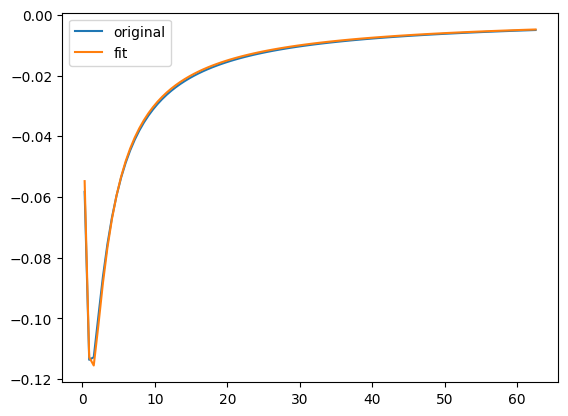

In [79]:

v = np.array([0.5, 0.25])
eps = np.array([1.14, 3.])
N =100
omegas = [(2 * n + 1) * 2 * np.pi / beta for n in range(N)]
delta = np.array([sum(v ** 2 / (1j*om - eps)) for om in omegas])
n = 1
x, pcov = fit_curve(delta, omegas, n)
delta_fit = delta_appro(omegas, *x)
print("x = ", x)
print("pcov =", pcov)
delta_fit = delta_fit[:len(delta_fit)//2] + 1j*delta_fit[len(delta_fit)//2:]

plt.plot(omegas, delta.imag, label = "original")
plt.plot(omegas, delta_fit.imag, label = "fit")
plt.legend()